## Project 4 - Bayesian Calculations

**Exercise 1:**

Create a Bayesian Regression class that takes a log posteriori, data points, number of walkers, etc as initialization and provides all required methods and attributes required for Bayesian Regression Problems. The class should also be able to provide an integration method that allows you to integrate with respect to the posteriori distribution. Additionally, the class should allow to calculate all probabilities including the predictive distribution. Also include methods for visualization such as corner maps. Even though this class is part of a project you should consider it as your first self build Data Science tool. 

### All about that Bayes

The Bayes_Watch class conducts a Bayes regression analysis using the following inputs from the user: a log likelihood function, a log prior function, observed data, the number of walkers and number of steps for the Markov Chain Monte Carlo simulation, and a list of variables used in the regression. This code has been updated so the the log likelihood and prior, as well as the regression, can be passed through the Class as opposed to hardcoded in. I expect additional alterations to this project will be made as I use it with other datasets. In particular, I would like to add a method that addresses the bonus questions posed in exercise 2 of this assignment.

Bayes_Watch contains the following methods:
- Runs the Markov Chain Monte Carlo simulation upon instantiation of a class object (100,000 steps per walker).
- estimate_model_parameters: Estimates model parameters of our regression.
- plot_scatter: Creates a scatter plot of our data.
- plot_regression: Creates a scatter plot of our data as well as our regression model.
- plot_probability_density: Plots the probability density of our model parameters.
- plot_corner: Creates a corner plot of our model parameters.
- predict_distribution: Creates a predictive distribution of values based on a user-specified time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.special import gamma
from math import log
import emcee
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import corner
import collections
%matplotlib inline

class Bayes_Watch(object):
    """Accepts four arguments: Atom log likelihood, prior log, input data, number of walkers (must be even), 
    number of steps, vertical offset of the MCMC and list of variables."""
    def __init__(self, atom, prior, data, walkers, steps, vertical_offset, variable_names):
        atom_log = atom
        prior_log = prior
        likelihood_log = lambda x: np.sum([atom_log(x)(e) for e in self.data])
        lnprob = lambda x: likelihood_log(x) + prior_log(x)
        self.data = data
        self.steps = steps
        self.walkers = walkers
        self.variable_names = variable_names
        self.parameter_values_w_labels = []
        self.parameter_values = []
        self.vertical_offset = vertical_offset
        
        #Monte Carlo for predictive distribution
        self.MonteCarlo = lambda f: 1/float(len(self.samples))*sum([f(e) for e in self.samples])

        #Run markov chain monte carlo
        p0 = np.random.rand(self.walkers*len(self.variable_names))\
             .reshape((self.walkers,len(self.variable_names)))*self.vertical_offset
        self.sampler = emcee.EnsembleSampler(self.walkers, len(self.variable_names), lnprob)
        pos, prob, state = self.sampler.run_mcmc(p0, 1000)
        self.sampler.reset()
        pos, prob, state = self.sampler.run_mcmc(pos, self.steps)
        self.samples = self.sampler.flatchain
        print ('init and mcmc complete.')
    
    def estimate_model_parameters(self):
        '''Call using () to set values of model parameters'''
        self.parameter_values = self.MonteCarlo(lambda x: x)
        self.parameter_values_w_labels = zip(self.variable_names, self.parameter_values)
        return self.parameter_values_w_labels
    
    def plot_scatter(self, title = 'Data scatter plot', x_label = 'x', y_label = 'y'):
        '''Create a scatter plot of data. Title="Regression over data"; x_label="x"; y_label="y"'''
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (5,3))
        ax.scatter(T,X)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend(loc = 'best', fontsize='small')
        ax.grid()
        
    def plot_regression(self, regression, reg_plot_range=(-20,20), \
                        title = 'Regression over data', x_label = 'x', y_label = 'y'):
        '''Create a scatter plot of data and regression line. Regression formula; reg_plot_range=(-20,20); 
        Title="Regression over data"; x_label="x"; y_label="y"'''
        Xval = np.arange(reg_plot_range[0],reg_plot_range[1],0.01) 
        Reg = np.array([regression(x)(self.parameter_values) for x in Xval])
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (5,3))
        ax.scatter(T,X)
        ax.plot(Xval, Reg, label = title, color = 'red')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend(loc = 'best', fontsize='small')
        ax.grid()

    def plot_probability_density(self):
        sample_data = pd.DataFrame(self.samples, columns =[self.variable_names[0], self.variable_names[1], 
                                                           self.variable_names[2], self.variable_names[3]])
        sample_data.plot(kind = 'density')

    def predict_distribution(self, time, func, title="Predictive Distribution"):
        '''Plots prediction distribution around a user-specified time. Inputs: self; time (float); function; 
           title="Predictive Distribution".'''
        self.title = title
        self.time = time
        self.func = func
        predictiveDist = lambda x: np.vectorize(lambda t: self.MonteCarlo(lambda d: self.func(t,x)(d)))
        Xval = np.arange(0,25)
        plt.plot(Xval,predictiveDist(self.time)(Xval))
        plt.title(self.title)
    
    def plot_corner(self):
        fig = corner.corner(self.samples, labels=self.variable_names)


/Users/johnsnyder/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


**Exercise 2:**

The data below is in the form (x,t) and represents the height x of the tide at a specific location over the course of a day. Time is represented by the variable t. Build a Bayesian Regression Model using your class from Exercise 1. Show us what your new class can do!
* Start by describing the data. What type of functional behavior do you anticipate? 
* Use your model to make a prediction about the future. 
* Create a corner plot.
* What can you say about the variance of your model parameters and what does that mean?

*Bonus!!* 
* What is the probability that the tide is higher than 15 during a day.
* What is the probability that the tide is lower than 5 during a day.

###### Response
Looking at our data, it's clear that it is following some sort of sine wave. Given this is data for tides, this makes sense. Tides follow a periodic motion with lows and highs over relatively consistent periods.

In [2]:
data = [(12.676817787115283, 4.840968499185621),
 (3.0635215093963133, 3.14922059397124),
 (8.9357879700357667, 5.431164887988198),
 (13.150389074317657, 0.2734372074578954),
 (12.925121692101902, 5.02106046462978),
 (10.269853674176913, 3.7776881451798454),
 (8.5618490817719284, 1.7531496843623315),
 (11.652310665546354, 0.13740741237008774),
 (15.785676964359141, 0.1589401373556326),
 (10.709910995988764, 1.405806821770987),
 (7.1341191045745171, 5.791539306670335),
 (21.883583042704814, 5.375575646320319),
 (9.3509495831601566, 1.5283167578387404),
 (8.9421204746670746, 1.2943521169392636),
 (7.9107785943448947, 2.41326855106268),
 (6.6761875778137583, 5.605375440538395),
 (11.650996974527924, 4.935997586415922),
 (17.290020321649969, 5.274010438371379),
 (13.06634684581484, 0.2347909715055829),
 (9.2602800850011402, 1.9716673533870746),
 (13.919837953941261, 5.528598466510076),
 (7.9171739378319606, 5.84750784658713),
 (12.864499776009934, 0.8278490177929644),
 (10.571617689971236, 2.36723797633488),
 (15.697626403745566, 6.217581078023053),
 (6.9542139194365262, 3.1860455750181425),
 (13.120156492593505, 4.864593354788696),
 (11.454973850882114, 1.8798442605946453),
 (10.614021877252608, 0.8044135861997307),
 (7.568300166951679, 2.673290291826998),
 (10.183500038106194, 1.309623551484031),
 (13.503996786942462, 0.04020573153381622),
 (14.908454853041013, 5.049774593191907),
 (16.502324161297746, 5.406433813862234),
 (7.7831240000772652, 5.45198929005635),
 (2.7144705188261025, 4.10012261788714),
 (6.3268913726889187, 5.6611505113173575),
 (9.343465517423013, 3.2971190116581632),
 (10.029091959312348, 0.5986208146884879),
 (12.078957723820951, 0.3853462849024228),
 (12.542705834818268, 1.5820979005652125),
 (9.8489274946698337, 2.6735253975153426),
 (11.349497927312719, 1.1055955472925354),
 (11.06556939865615, 2.5611692213120962),
 (11.242786106546351, 0.6500902431293415),
 (7.5720317139333542, 3.4428084142928075),
 (10.19301456907124, 2.427329872753534),
 (11.688185995125892, 0.14941531339444405),
 (13.321217017544326, 4.226862591173392),
 (9.2226853401109601, 2.3990630763955374),
 (7.0737562512314449, 0.8821159241146929),
 (5.5158907409668556, 2.287657630597947),
 (5.2424711689478309, 3.4418528431658317),
 (11.826235109408199, 3.3038133315910185),
 (6.2478202112864949, 3.7493402648869223),
 (7.2776616254733053, 2.666108760536187),
 (14.728663233221567, 5.923646379789856),
 (11.088563226667782, 2.974838497958867),
 (11.458847468046265, 1.2931851555147837),
 (4.0709653063610656, 2.4390760560779694),
 (15.530850378396899, 0.7685325485891545),
 (11.615168564683962, 2.7271570577326223),
 (10.632288760396049, 5.37570954124343),
 (6.9102179020649883, 1.9530381191410195),
 (7.1344237045084675, 1.6373486764522571),
 (2.4211573415830188, 2.810112760589519),
 (7.6108111175276107, 4.181915055702122),
 (9.6538205198090434, 4.444382820070389),
 (8.1905132263562983, 3.0534156042900285),
 (7.4546566492388493, 5.388475797989607),
 (14.087818085722649, 4.961727257154151),
 (7.2780971375915371, 2.54178907740794),
 (13.49355600611988, 2.493864649506947),
 (7.1166182479555999, 3.0195450895358524),
 (13.861336288014931, 6.246482002469356),
 (9.9498449141955589, 1.5817110088866608),
 (12.090250168282912, 3.990269038499848),
 (14.0111497595614, 0.9108297343631235),
 (9.3928518482934216, 3.3950553805254793),
 (8.2709147406350212, 3.214121983305056),
 (8.386404092046515, 2.1119573572471135),
 (6.9673744914092852, 2.2083135342567983),
 (9.5162641851488523, 3.2184133097802943),
 (17.967580316152478, 3.965622119805391),
 (15.832368008468372, 0.828357131652206),
 (5.3317615928107358, 2.6644501925548774),
 (5.8971983697046877, 3.0341229253117494),
 (17.963906775041007, 6.0469989006758444),
 (5.6300726881847361, 2.4077579346402826),
 (11.348534324413565, 3.8699231013565725),
 (10.028167958705753, 1.9397974132848168),
 (14.062219131934697, 4.41603067403343),
 (9.10707255345568, 0.8011371320017451),
 (10.567716164156263, 4.450436137829604),
 (10.928830310193101, 4.839816330906595),
 (11.681478622619728, 0.8572196990559613),
 (11.538949263967641, 5.760338188965996),
 (10.978084516398958, 4.49756314191279),
 (12.818751132975834, 4.411544813273495),
 (6.7181748281785731, 5.484421751460473)]

In [3]:
#model - takes prior log, likelihood log, - data and model parameters
prior_log = lambda x: -0.5 * (x[0]**2 + x[1]**2 + x[2]**2 ) - x[3] 

variables = ['Omega0', 'Omega1', 'Omega2', 'Lambda']

regression = lambda t: lambda m: m[0] + m[1]*np.sin(t) + m[2]*np.cos(t)

atom_log = lambda x: lambda e: -np.infty if x[3] < 0 else 0.5 * np.log(x[3])-(x[3]/2)*\
                                (e[0]-(x[0]+x[1]*np.sin(e[1]) + x[2] * np.cos(e[1])))**2

tides_run1 = Bayes_Watch(atom_log, prior_log, data, 20, 100000, 10, variables)


init and mcmc complete.


In [4]:
tides_run1.estimate_model_parameters()

[('Omega0', 9.4673596797193476),
 ('Omega1', -0.632600603219867),
 ('Omega2', 1.7729359777975076),
 ('Lambda', 0.095595571960681622)]

/Users/johnsnyder/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


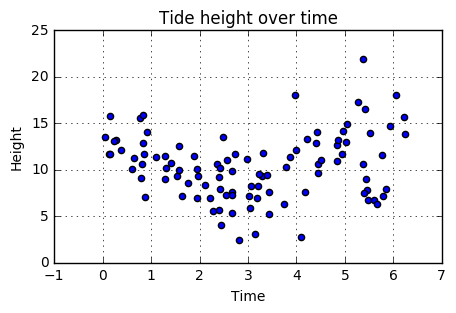

In [5]:
# Create our scatter plot.
tides_run1.plot_scatter('Tide height over time',"Time","Height")

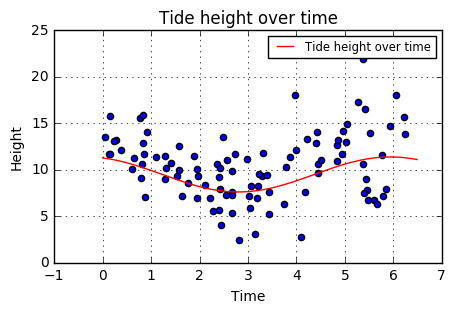

In [6]:
tides_run1.plot_regression(regression,(0,6.5),'Tide height over time',"Time","Height")

In [7]:
tides_run1.parameter_values

array([ 9.46735968, -0.6326006 ,  1.77293598,  0.09559557])

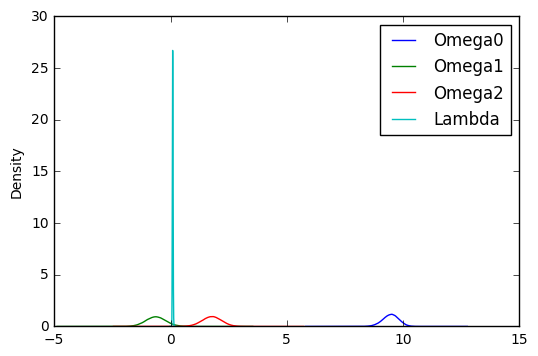

In [8]:
# Create probability density graph
tides_run1.plot_probability_density()

By looking at our graph above, we can see that our precision, Lambda, is very certain, and our parameters, Omegas 1, 2, and 3, are fairly certain, since the variance of their curves are somewhat wide. This makes sense, considering that the scatter plot of our data deviates quite a bit from our regression line.

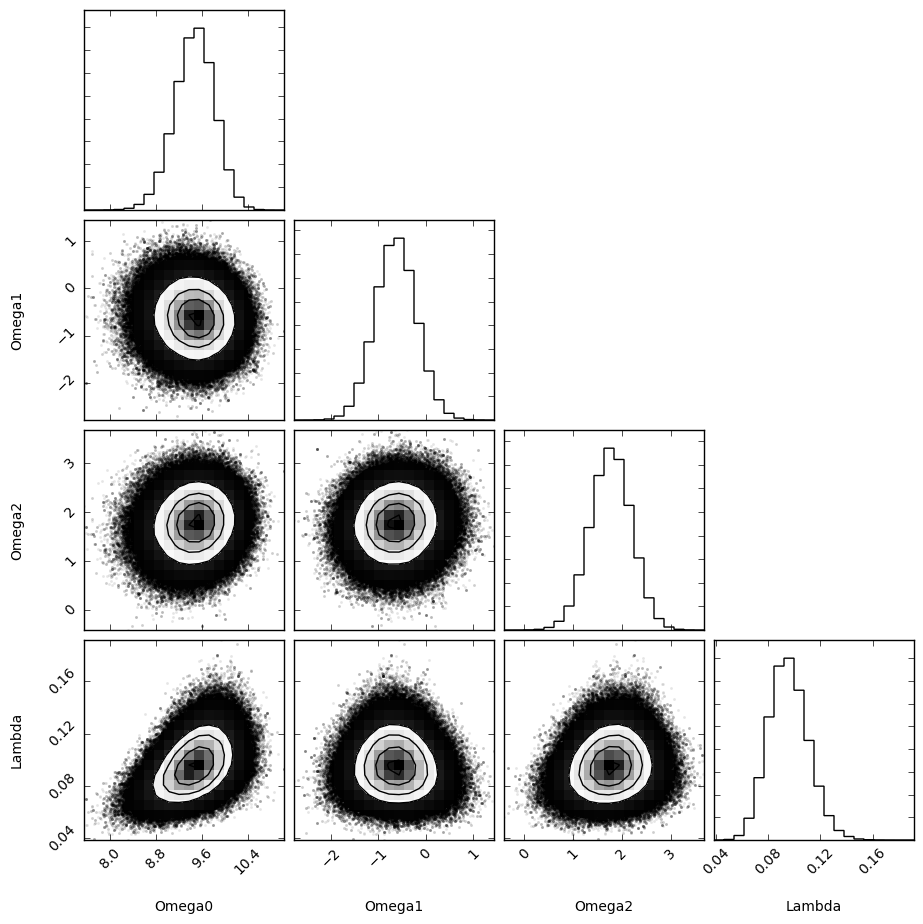

In [9]:
# Create corner plot of our regression.
tides_run1.plot_corner()

In [ ]:
Predictor = lambda x, t: lambda d: np.sqrt(d[3]/(2*np.pi)) *\
                               np.exp(-0.5 * d[3] * (x - (d[0] + d[1]* np.sin(t) + d[2] * np.cos(t)))**2)

tides_run1.predict_distribution(9,Predictor)

The above graph shows that at time 9, the tide has the highest likelihood (about 12%) of being around 8 feet tall.